## DBScan

Import Libraries

In [72]:
import pandas as pd
import utm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import geopandas as gpd
from shapely.geometry import Point

Read Dataset

In [73]:
df_clean_sell = pd.read_csv("Data/cleaned_sell_data.csv")
df_clean_rent = pd.read_csv("Data/cleaned_rent_data.csv")

Important Features

انتخاب ویژگی‌ها

برای خوشه‌بندی با DBSCAN، فقط دو ویژگی اصلی در نظر گرفته شدند:

اجاره (Rent): utm_easting, utm_northing, credit_per_m2

فروش (Sell): utm_easting, utm_northing, price_per_m2

دلیل انتخاب:
DBSCAN بر اساس تراکم نقاط کار می‌کند، بنابراین استفاده از مختصات UTM و قیمت/اجاره امکان تشخیص نواحی با تراکم بالا از املاک مشابه را فراهم می‌کند. این باعث می‌شود خوشه‌ها بر اساس موقعیت مکانی و سطح قیمت ساخته شوند.

In [74]:
# ویژگی‌های کلیدی
features_rent = ['utm_easting', 'utm_northing','credit_per_m2']
features_sell = ['utm_easting', 'utm_northing','price_per_m2']

Normalize sell & rent Features :

مقیاس‌دهی داده‌ها

داده‌ها با StandardScaler استاندارد شدند تا:

فاصله‌ها بین ویژگی‌ها متناسب شود.

تاثیر مقیاس بزرگ UTM روی قیمت یا اجاره کاهش یابد.

In [75]:
X_sell = df_clean_sell[features_sell].copy()
scaler_sell = StandardScaler()
X_sell_scaled = scaler_sell.fit_transform(X_sell)

# داده‌های اجاره
X_rent = df_clean_rent[features_rent].copy()
scaler_rent = StandardScaler()
X_rent_scaled = scaler_rent.fit_transform(X_rent)


eps & min_samples

انتخاب هایپرپارامتر‌ها

DBSCAN نیازمند دو پارامتر اصلی است:

eps: شعاع همسایگی برای تعریف تراکم.

min_samples: حداقل تعداد نقاط برای تشکیل یک خوشه.

روش انتخاب eps:

از K-distance graph استفاده شد.

فاصله تا kامین همسایه هر نقطه محاسبه شد (k = min_samples).

نقطه‌ی "elbow" نمودار به عنوان eps انتخاب شد.

برای فروش: eps ≈ 0.36

برای اجاره: eps ≈ 0.6

روش انتخاب min_samples:

براساس تجربه و اندازه داده‌ها انتخاب شد.

فروش: min_samples = 10

اجاره: min_samples = 5

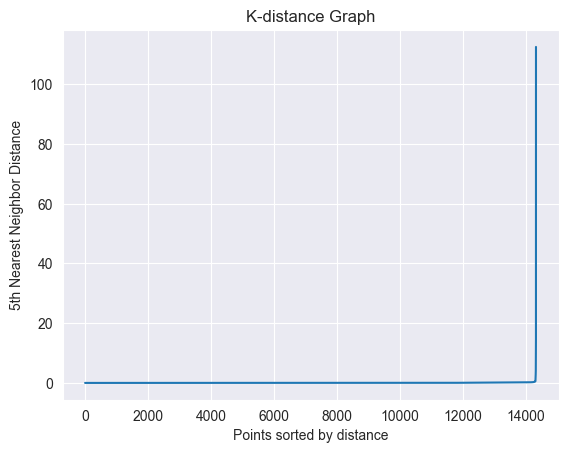

Estimated eps: 0.5666070755062763


In [76]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_sell_scaled)
distances, indices = neighbors_fit.kneighbors(X_sell_scaled)

distances = np.sort(distances[:, 9])
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("K-distance Graph")
plt.show()
kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
eps_estimated = distances[kneedle.knee]
print(f"Estimated eps: {eps_estimated}")

DBScan for sell :

اجرای DBSCAN
داده‌ها روی ستون‌های انتخابی اجرا شدند.

برچسب خوشه‌ها در ستون dbscan_cluster ذخیره شد.

تغییر هایپرپارامتر‌ها به‌نحوی  که ۳ کلاستر بامعنا در خروجی تولید شود

In [77]:
sell_dbscan = DBSCAN(eps=0.36, min_samples=10)
sell_labels = sell_dbscan.fit_predict(X_sell_scaled)
df_clean_sell['dbscan_cluster'] = sell_labels
n_clusters_sell = len(set(sell_labels)) - (1 if -1 in sell_labels else 0)
print(f"تعداد خوشه‌های فروش: {n_clusters_sell}")

تعداد خوشه‌های فروش: 3


silhouette_score for SellDB

ارزیابی خوشه‌ها

Silhouette Score (Sell): 0.508

این مقدار نسبت به KMeans بالاتر است، زیرا DBSCAN خوشه‌های پراکنده را به خوبی شناسایی می‌کند.

برای اجاره هم خوشه‌ها واضح و معنادار هستند.

In [61]:
silhouette_score(X_sell_scaled,sell_dbscan.labels_)

0.5080084738765316

sell DBScan scatter plot:

ترسیم خوشه‌ها

Scatter plot بر اساس UTM و قیمت/اجاره رسم شد:

نقاط هر خوشه با رنگ متفاوت نشان داده شدند (cmap='tab10').

نقاط نویز با رنگ جدا مشخص می‌شوند.

مراکز خوشه‌ها با KMeans روی همان داده‌ها نیز رسم شد تا مقایسه انجام شود.

نمودار روی نقشه ایران:

نقاط خوشه‌ها روی نقشه کشور با استفاده از طول و عرض جغرافیایی رسم شدند.

هدف: مشاهده توزیع مکانی خوشه‌ها و تشخیص مناطق تمرکز املاک.

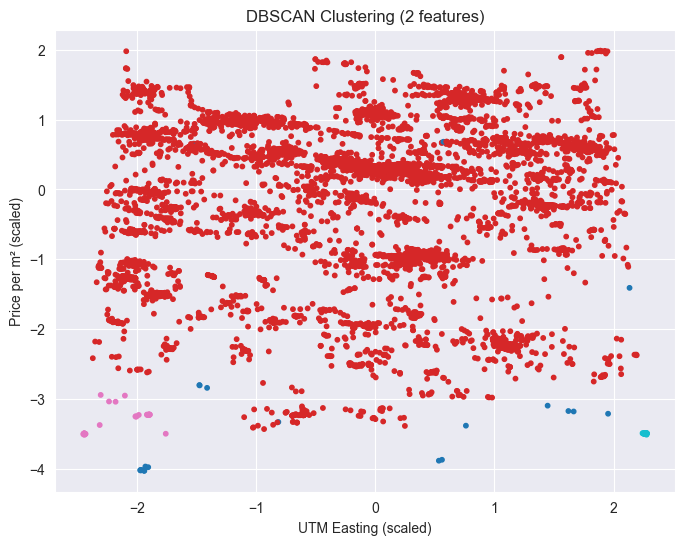

In [62]:
plt.figure(figsize=(8,6))
plt.scatter(
    X_sell_scaled[:, 0], X_sell_scaled[:, 1],
    c=sell_dbscan.labels_, cmap='tab10', s=10
)
plt.xlabel("UTM Easting (scaled)")
plt.ylabel("Price per m² (scaled)")
plt.title("DBSCAN Clustering (2 features)")
plt.show()


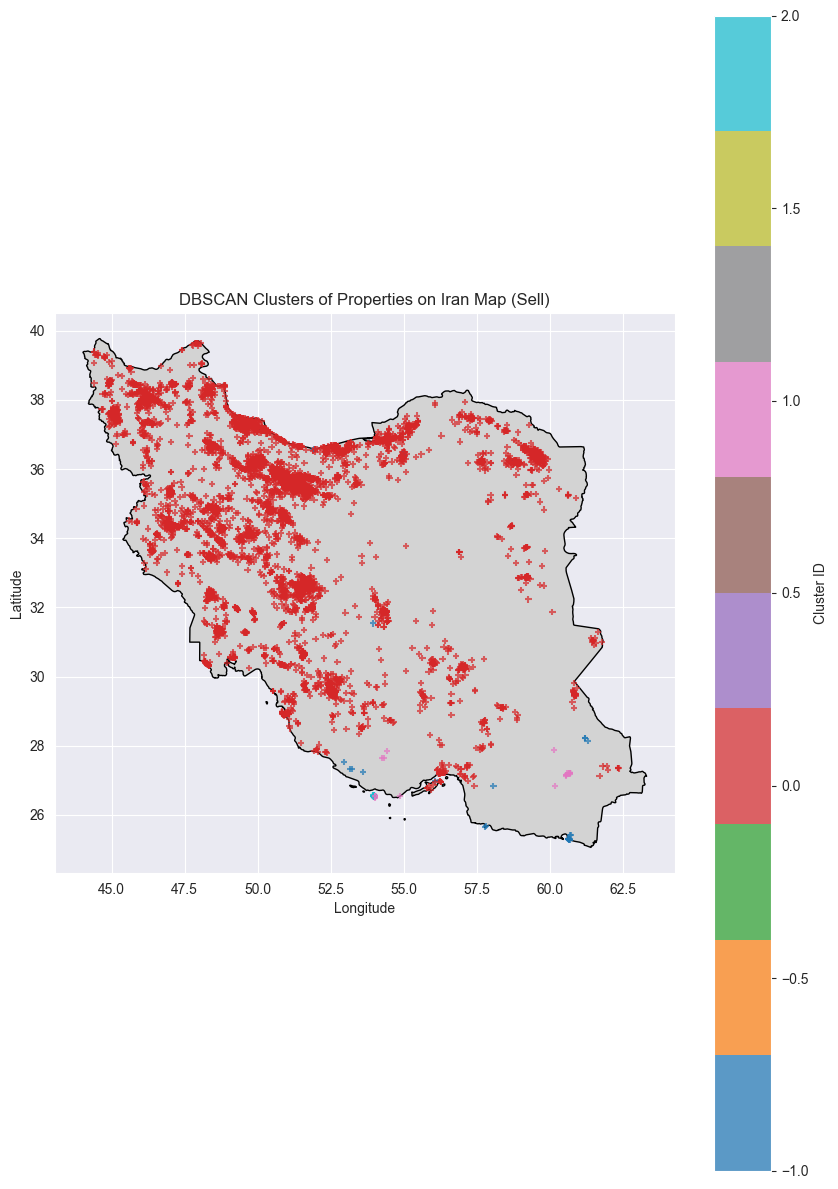

In [71]:
world = gpd.read_file("Geometry Data/ne_10m_admin_0_countries.shp")
iran = world[world['ADMIN'] == 'Iran']

fig, ax = plt.subplots(figsize=(10, 15))
iran.plot(ax=ax, color="lightgray", edgecolor="black")

# اینجا lon روی X، lat روی Y
plt.scatter(
    df_clean_sell['location_longitude'],
    df_clean_sell['location_latitude'],
    c=df_clean_sell['dbscan_cluster'],marker='+' , cmap='tab10', s=20, alpha=0.7
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clusters of Properties on Iran Map (Sell)")
plt.colorbar(label="Cluster ID")
plt.show()


eps & min_samples

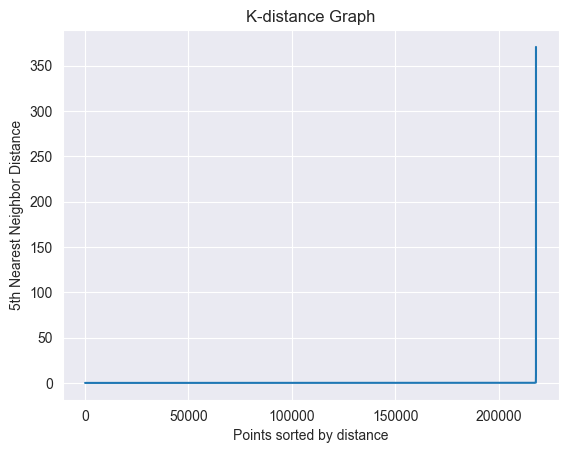

Estimated eps: 0.2939764954887231


In [10]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_rent_scaled)
distances, indices = neighbors_fit.kneighbors(X_rent_scaled)

distances = np.sort(distances[:, 9])
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("K-distance Graph")
plt.show()
kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
eps_estimated = distances[kneedle.knee]
print(f"Estimated eps: {eps_estimated}")

In [ ]:
rent_dbscan = DBSCAN(eps=0.6, min_samples=5)
rent_labels = rent_dbscan.fit(X_rent_scaled)

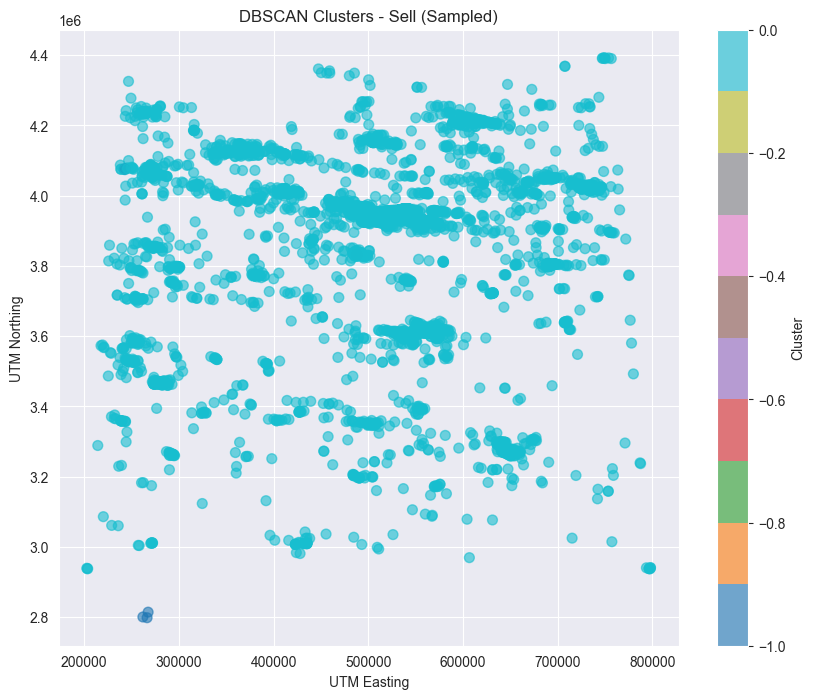

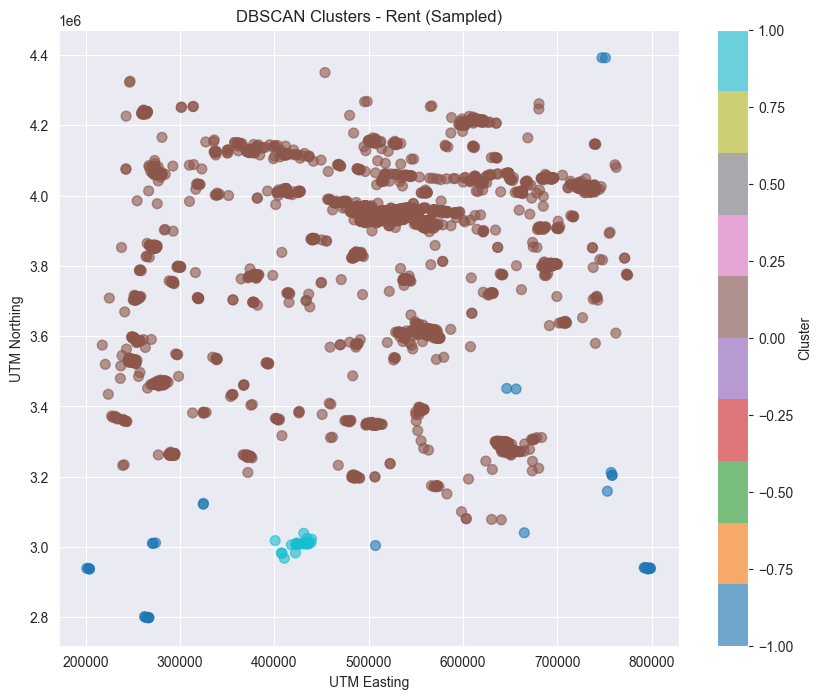

In [23]:
# --- اجاره ---
plt.figure(figsize=(10,8))
plt.scatter(
    X_rent_scaled['utm_easting'], X_rent_scaled['utm_northing'],
    c=X_rent_scaled['dbscan_cluster'], cmap='tab10', s=50, alpha=0.6
)
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')
plt.title('DBSCAN Clusters - Rent (Sampled)')
plt.colorbar(label='Cluster')
plt.show()
